In [ ]:
# https://blog.csdn.net/weixin_45063703/article/details/119856737?utm_medium=distribute.pc_aggpage_search_result.none-task-blog-2~aggregatepage~first_rank_ecpm_v1~rank_v31_ecpm-1-119856737-null-null.pc_agg_new_rank&utm_term=cnn结合lstm的优势&spm=1000.2123.3001.4430

# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

Length of the data set: 144


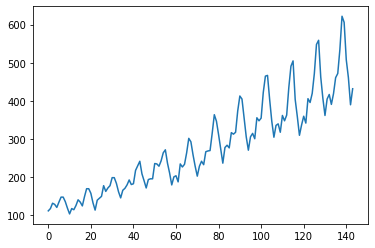

In [8]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#matplotlib inline

# load the dataset
dataframe = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv', 
                     usecols=[1], engine='python')
# print(dataframe)
print("Length of the data set:",len(dataframe))
dataset = dataframe.values
# int2float
dataset = dataset.astype('float32')

plt.plot(dataset)
plt.show()

In [9]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(7)


scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)


train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print("Length of the original training set:",train_size)
print("Length of the original test set",test_size)



look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back) 
print("Turn to supervised learning, training set data length:", len(trainX))
# print(trainX,trainY)
print("Turn to supervised learning, test the data length of the set:",len(testX))
# print(testX, testY )
trainX = numpy.reshape(trainX, (trainX.shape[0], 1,1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0],1, 1, testX.shape[1]))
print('Construct the input data of the model (the training data has been labeled trainY):',
      trainX.shape,testX.shape)



Length of the original training set: 96
Length of the original test set 48
Turn to supervised learning, training set data length: 94
Turn to supervised learning, test the data length of the set: 46
Construct the input data of the model (the training data has been labeled trainY): (94, 1, 1, 1) (46, 1, 1, 1)


In [11]:
# create and fit the LSTM network
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(None,1, testX.shape[1]))))
model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(4,activation='relu'))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.fit(trainX, trainY, epochs=50)

Epoch 1/50
3/3 [==============================] - 1s 3ms/step - loss: 0.0771
Epoch 2/50
3/3 [==============================] - 0s 6ms/step - loss: 0.0718
Epoch 3/50
3/3 [==============================] - 0s 12ms/step - loss: 0.0675
Epoch 4/50
3/3 [==============================] - 0s 10ms/step - loss: 0.0635
Epoch 5/50
3/3 [==============================] - 0s 7ms/step - loss: 0.0603
Epoch 6/50
3/3 [==============================] - 0s 5ms/step - loss: 0.0580
Epoch 7/50
3/3 [==============================] - 0s 8ms/step - loss: 0.0563
Epoch 8/50
3/3 [==============================] - 0s 5ms/step - loss: 0.0551
Epoch 9/50
3/3 [==============================] - 0s 9ms/step - loss: 0.0539
Epoch 10/50
3/3 [==============================] - 0s 7ms/step - loss: 0.0529
Epoch 11/50
3/3 [==============================] - 0s 3ms/step - loss: 0.0518
Epoch 12/50
3/3 [==============================] - 0s 7ms/step - loss: 0.0508
Epoch 13/50
3/3 [==============================] - 0s 5ms/step - loss: 

In [12]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_15 (TimeDi  (None, 1, 1, 64)         128       
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 1, 1, 64)         0         
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 1, 64)            0         
 stributed)                                                      
                                                                 
 lstm_5 (LSTM)               (None, 4)                 1104      
                                                                 
 dense_5 (Dense)             (None, 1)                 5         
                                                      

2/2 [==============================] - 0s 2ms/step
Train Score: 84.35 RMSE
Test Score: 259.11 RMSE


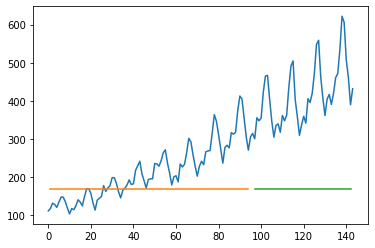

In [13]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()